In [2]:
# import packages
import torch
import yfinance as yf
import numpy as np
import paddle
import numpy as np
np.object = object
from paddle_quantum.gate import BasisEncoding, AmplitudeEncoding, AngleEncoding, IQPEncoding
import matplotlib.pyplot as plt
from qiskit_machine_learning.utils import algorithm_globals
from torch import nn
import pandas as pd


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
I0116 19:51:27.024694 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 19:51:27.024761 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 19:51:27.024945 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 19:51:27.025041 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 19:51:27.025045 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 19:51:27.026046 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 19:51:27.026103 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 19:51:27.026108 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 19:51:27.026147 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 19:51:27.026160 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 19:51:27.026163 4266476096

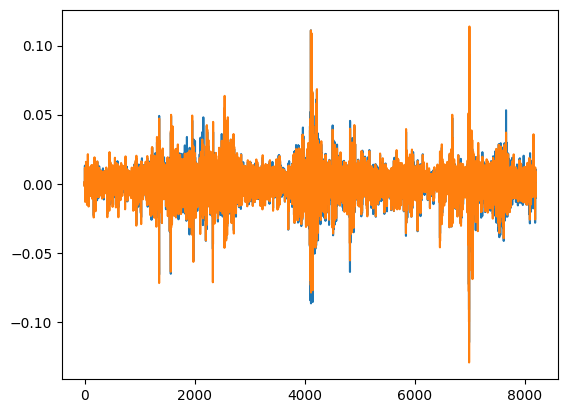

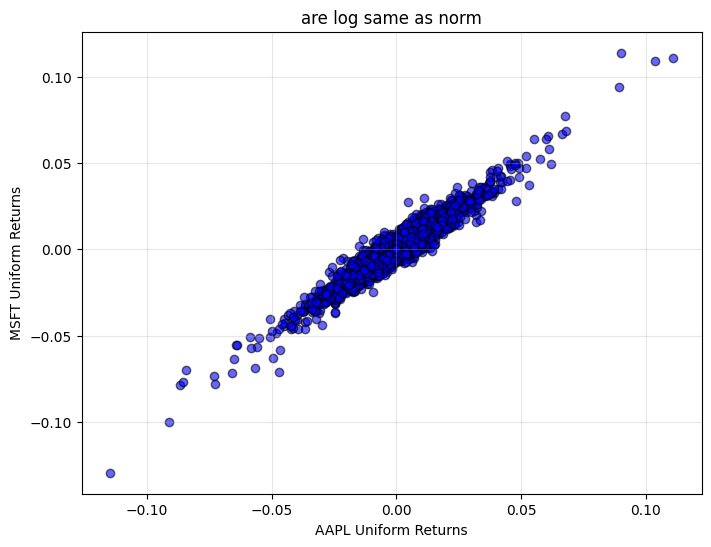

In [35]:
#load dataset

sp500 = yf.download('^GSPC', start='1992-06-19', end='2024-12-31')
dowjones = yf.download('^DJI', start='1992-06-19', end='2024-12-31')

# Compared to the Apple and Microsoft plot they have in the paper, this gives a similar result. To get it using amplitude encoding,
# we do need to preprocess the data as we were doing before, so putting it in a probability distribution.
sp500_returns = sp500['Close'].pct_change().dropna()
sp_returns = sp500_returns.values

dowjones_returns = dowjones['Close'].pct_change().dropna()
dj_returns = dowjones_returns.values


# encode in state amplitude
# We have 8192 datapoints, so we need 13 qubits to encode them
qubits = 13

amplitude_enc = AmplitudeEncoding(num_qubits=qubits)
x,y = paddle.to_tensor(sp_returns), paddle.to_tensor(dj_returns)
state1,state2 = amplitude_enc(x), amplitude_enc(y)

data_im1,data_im2 = state1.numpy().tolist(), state2.numpy().tolist()
data1,data2 = np.real(data_im1), np.real(data_im2)
plt.plot(data1)
plt.plot(data2)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(data1, data2, alpha=0.6, c='blue', edgecolor='k')
plt.title("are log same as norm")
plt.xlabel("AAPL Uniform Returns")
plt.ylabel("MSFT Uniform Returns")
plt.grid(alpha=0.3)
plt.show()

data = np.column_stack((data1,data2))
df = pd.DataFrame({
    'Stock1': data1,
    'Stock2': data2
})

In [43]:
from copulas.bivariate import Clayton
from copulas.multivariate import GaussianMultivariate
copulas2 = GaussianMultivariate()
copulas2.fit(df)
copulas = Clayton()
copulas.fit(data)
samples = copulas2.sample(100)
samples = pd.DataFrame(samples, columns=['Stock1', 'Stock2'])

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6363: RuntimeWarning:

divide by zero encountered in power

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6363: RuntimeWarning:

divide by zero encountered in power

/opt/anaconda3/lib/python3.12/site-packages/copulas/bivariate/base.py:163: RuntimeWarning:

Data does not appear to be uniform.



In [44]:
from copulas.visualization import compare_2d

compare_2d(df, samples)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>


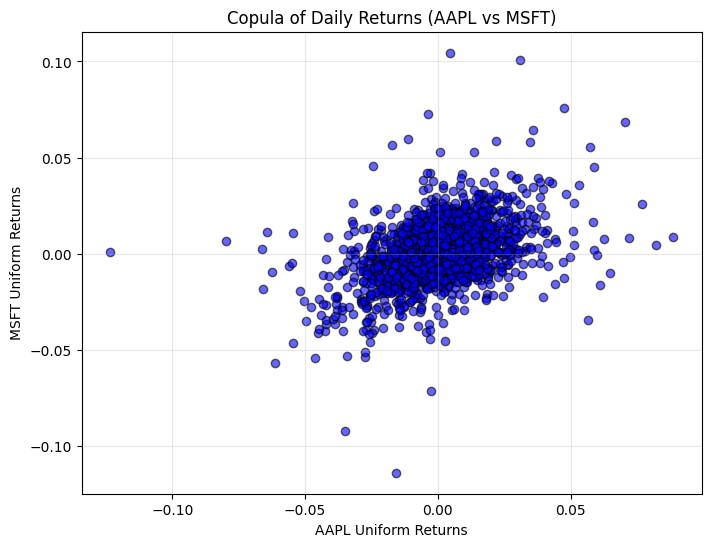

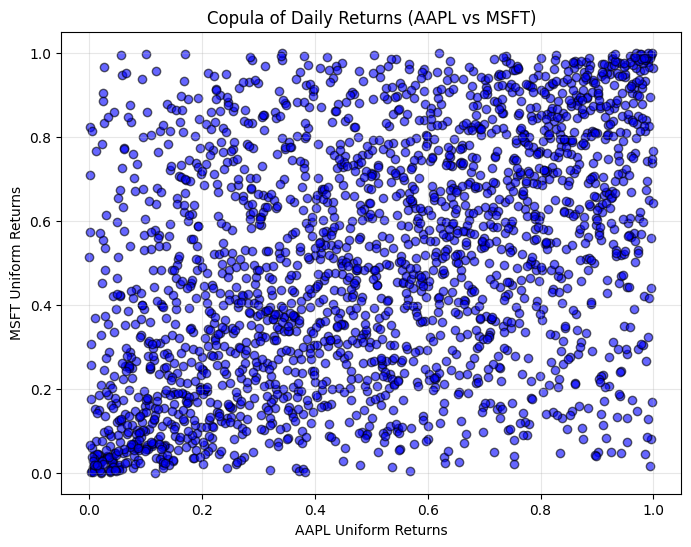

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt



/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6363: RuntimeWarning:

divide by zero encountered in power

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6363: RuntimeWarning:

divide by zero encountered in power

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6363: RuntimeWarning:

divide by zero encountered in power

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6363: RuntimeWarning:

divide by zero encountered in power



In [41]:
# Just using this to compare with the scatter plot that we have, cause this one is the one we're "aiming for".

from scipy.stats import rankdata

# Step 1: Download historical stock data
start_date = "2010-01-01"
end_date = "2018-12-31"

aapl = yf.download("AAPL", start=start_date, end=end_date)["Adj Close"]
msft = yf.download("MSFT", start=start_date, end=end_date)["Adj Close"]

print(type(aapl))

# Step 2: Calculate daily returns
aapl_returns = aapl.pct_change().dropna()
msft_returns = msft.pct_change().dropna()

# Step 3: Transform returns to uniform distribution (ECDF)
def empirical_cdf(data):
    ranks = rankdata(data, method='average')  # Rank the data
    uniform_data = ranks / (len(data) + 1)    # Normalize to [0, 1]
    return uniform_data

aapl_uniform = empirical_cdf(aapl_returns)
msft_uniform = empirical_cdf(msft_returns)

# Step 4: Create a scatter plot (copula)
plt.figure(figsize=(8, 6))
plt.scatter(aapl_returns, msft_returns, alpha=0.6, c='blue', edgecolor='k')
plt.title("Copula of Daily Returns (AAPL vs MSFT)")
plt.xlabel("AAPL Uniform Returns")
plt.ylabel("MSFT Uniform Returns")
plt.grid(alpha=0.3)
plt.figure(figsize=(8, 6))
plt.scatter(aapl_uniform, msft_uniform, alpha=0.6, c='blue', edgecolor='k')
plt.title("Copula of Daily Returns (AAPL vs MSFT)")
plt.xlabel("AAPL Uniform Returns")
plt.ylabel("MSFT Uniform Returns")
plt.grid(alpha=0.3)
plt.show()

#i dont really understand copulas so i'm really not sure about this step

from copulas.bivariate import Clayton
from copulas.multivariate import GaussianMultivariate
copulas2 = GaussianMultivariate()
copulas2.fit(df)
copulas = Clayton()
copulas2.fit(data)
samples = copulas2.sample(100)
samples = pd.DataFrame(samples, columns=['Stock1', 'Stock2'])

from copulas.visualization import compare_2d

compare_2d(aapl_returns, msft_returns)

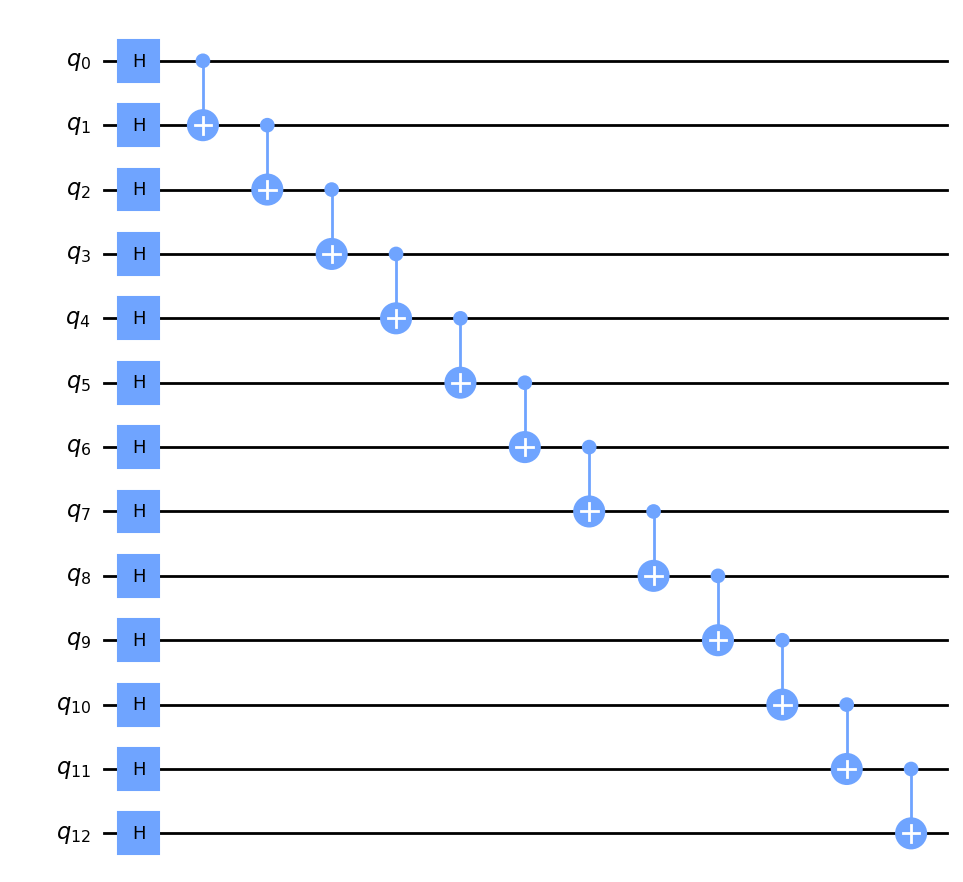

In [69]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RZGate, RXGate

# create the quantum circuit
qc = QuantumCircuit(qubits)

for qubit in range(qubits):
    qc.h(qubit)

for qubit in range(qubits - 1):
    qc.cx(qubit, qubit + 1)

qc.draw(output='mpl', style='clifford')

In [70]:
# define generator
class QuantumGenerator:
    def __init__(self, num_qubits, layers=1):
        self.num_qubits = num_qubits
        self.layers = layers
        self.params = np.random.uniform(0, 2 * np.pi, size=(layers, 2 * num_qubits))
        self.backend = AerSimulator()

    def circuit_building(self, params):
        for layer in range(self.layers):
            for qubit in range(self.num_qubits):
                qc.rz(params[layer, qubit], qubit)
                qc.rx(params[layer, qubit + self.num_qubits], qubit)
        
        print(qc.num_parameters)
        return qc


# define discriminator 
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 32)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear2 = nn.Linear(32,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x

In [71]:
generator = QuantumGenerator(qubits)
discriminator = Discriminator(2)

In [72]:
# define loss functions
# BCE loss function
def adversarial_loss(input, target, w):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

# WGAN loss function
def wgan_loss(pred, target_is_real):
    return -torch.mean(pred) if target_is_real else torch.mean(pred)

In [73]:
# add optimizers 

# SPSA optimizer

# Adam optimizer
from torch.optim import Adam

lr = 0.0001  # learning rate
b1 = 0.7  # first momentum parameter
b2 = 0.999  # second momentum parameter
discriminator_optimizer = Adam(discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)

In [74]:
# define plot function

In [75]:
# define training function